# Demonstration of dato

In [1]:
import sys
sys.path.insert(0, '/Users/robertyi/repos/dataframe/dato')
from dato import *
from dato.sampledata.datagen import user_data, purchase_data
import dato as dp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Create some synthetic data
Let's start by making some synthetic data. Below I use some boilerplate numpy + pandas code to generate some weekly fluctuating revenue data.

In [2]:
users = user_data(1000, random_state=2701)
purchases = purchase_data(1000)

## Overview of data
We have two tables:

* `users`
* `purchases`

These should roughly mirror the kind of information companies will typically log (if star schema is being used) -- dimension tables describing *states*, such as a user information table; fact tables describing *events*, such as a purchases or visits table.

We'll assume we've loaded these as `pd.DataFrame`s from your data lake. Let's see how we would traditionally parse these.

## Plotting

Even for basic plotting of time trends, this can be quite cumbersome. Tools like superset and tableau make this significantly easier, but for data scientists who like to stay within the python ecosystem, substantial cleaning will nonetheless be required.

### Histograms

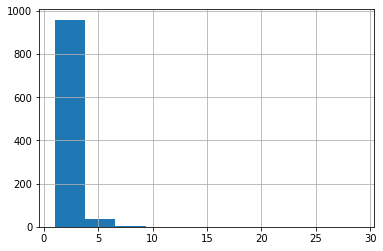

In [3]:
purchases.sale_value.hist()

Histograms are quite easy to plot, but typically some sort of log-scaling is necessary, especially for long-tailed distributions.

Iterations are usually required.

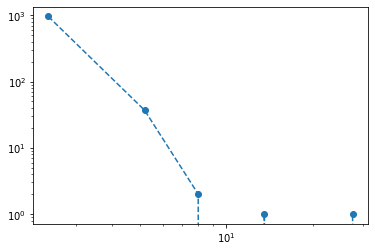

In [4]:
y, x = np.histogram(purchases.sale_value)
plt.plot((x[1:] + x[:-1])/2, y, 'o--')
plt.xscale('log')
plt.yscale('log')

`dato` makes this just as easy, but with a few small QOL improvements:

* Declarative syntax.
* Automatic ipython-suitable styling.
* Better defaults.

Moreover, the functions wrap matplotlib/pandas/numpy, so any arguments that apply to the base functions can be passed.

In [5]:
# We support dark mode (not on by default).
# Enabling it here because we like it.
import dato
dato.style.rc['style'] = 'dark_mode'

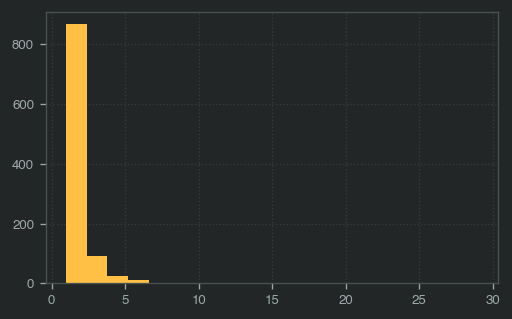

In [6]:
a = purchases.sale_value >> Hist(bins=20);

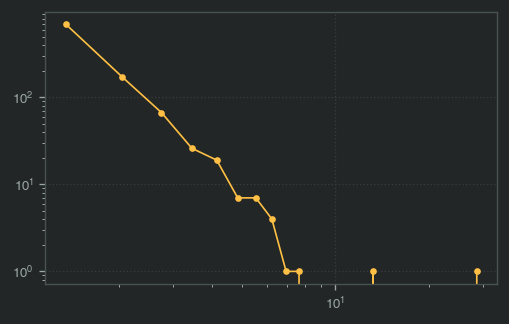

In [7]:
purchases.sale_value >> LogLogHist(bins=40)

## Scatter plots

In [8]:
a, b, c = np.array_split(users, 3)

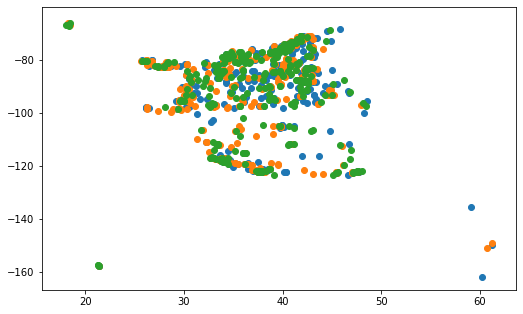

In [9]:
plt.figure(figsize=(8.5,5.2))
plt.scatter(a.lat, a.lng)
plt.scatter(b.lat, b.lng)
plt.scatter(c.lat, c.lng)

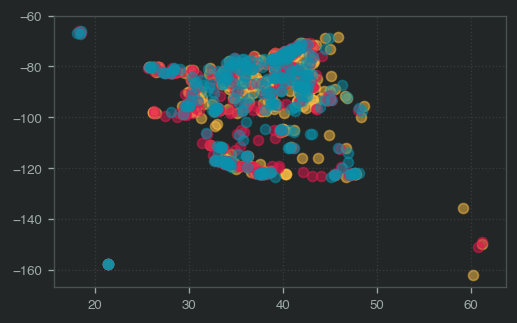

In [10]:
(a.lat, a.lng) >> Scatter
(b.lat, b.lng) >> Scatter()
(c.lat, c.lng) >> Scatter()

## Aggregations

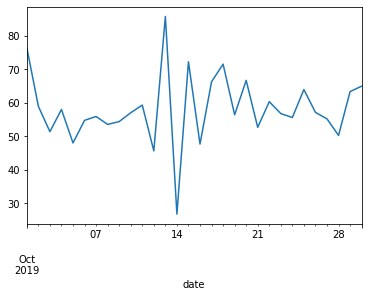

In [11]:
purchases_copy = purchases.copy()
purchases_copy['date'] = pd.to_datetime(purchases_copy.date)
gb = purchases_copy.groupby('date').sum()['sale_value']
gb.plot()

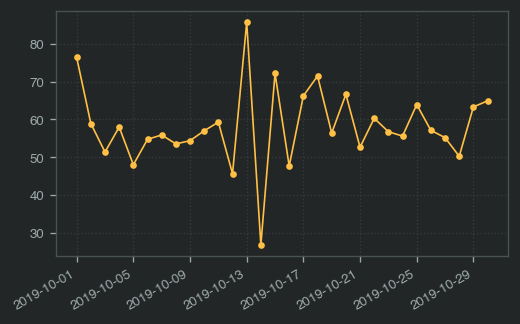

In [12]:
purchases >> ToDatetime('date') >> GroupBy('date') >> Sum('sale_value') >> Plot

## Light mode

In [13]:
import dato
dato.style.rc['style'] = 'light_mode'

In [14]:
purchases.\
    copy().\
    sample(100)

,id_user,date,sale_value
460,556.0,2019-10-09,1.058866
191,269.0,2019-10-13,1.822020
250,909.0,2019-10-01,2.992472
319,898.0,2019-10-13,3.817461
749,752.0,2019-10-07,1.321943
...,...,...,...
139,82.0,2019-10-09,1.071791
912,290.0,2019-10-29,1.458699
832,624.0,2019-10-26,1.623670
866,133.0,2019-10-12,2.777195


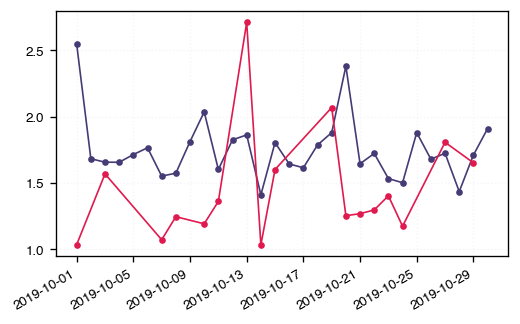

In [15]:
purchases >> ToDatetime('date') >> GroupBy('date') >> Mean('sale_value') >> Plot
new_purchases = purchases.sample(20, replace=True)
new_purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

## ML

In [16]:
modelspec = (users, purchases) \
    >> Merge(on='id_user') \
    >> Select('population', 'density', 'sale_value', 'city') \
    >> InitModel(label='sale_value') \
    >> LabelEnc(columns=['city']) \
    >> TrainTestSplit(random_state=2701) \
    >> LinearReg

Training set
------------ 
Max error: 5.190061158829579
Mean absolute error: 0.7569523223115795
Mean squared error: 1.474467254422875
Root mean squared error: 1.2142764324579782


Test set
-------- 
Max error: 1.3319266394300338
Mean absolute error: 0.5897121969986303
Mean squared error: 0.44689970844355853
Root mean squared error: 0.668505578468541


## Classifier

In [17]:
df = (users, purchases) \
    >> Merge(on='id_user')

# Create a mock "sales" column.
df['sales'] = (df['sale_value'] > 1.2).astype(int)

In [18]:
modelspec = df \
    >> Select('population', 'density', 'sales') \
    >> InitModel(label='sales') \
    >> TrainTestSplit(random_state=2701) \
    >> LogisticReg